In [65]:
from sqlalchemy.engine import Engine, Connection
from sqlalchemy import create_engine
from os import getenv
from typing import List, Dict, Optional
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

In [19]:
import sys
sys.path.insert(0, '..')

In [20]:
try:
    from dotenv import load_dotenv

    load_dotenv()
except:
    print('No ".env" file or python-dotenv not installed... Using default env variables...')

In [24]:
def db_connection() -> Engine:
    dbname: Optional[str] = getenv('POSTGRES_DB_NAME')
    host: Optional[str] = getenv('POSTGRES_HOST')
    user: Optional[str] = getenv('POSTGRES_USERNAME')
    password: Optional[str] = getenv('POSTGRES_PASSWORD')
    port: Optional[str] = getenv('POSTGRES_PORT')
        
    postgres_str: str = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'
    
    engine: Engine = create_engine(postgres_str)
    
    return engine

In [27]:
sql_energy: str = "SELECT * FROM sorgenia_energy"
engine: Engine = db_connection()

In [29]:
energy_df: DataFrame = pd.read_sql_query(sql_energy, con=engine)

In [33]:
energy_df.head()

,id,plant_name_up,start_date_utc,end_date_utc,kwh
0,188021,UP_PRCLCMINEO_1,2017-05-14 12:00:00+00:00,2017-05-14 12:15:00+00:00,181.50
1,188022,UP_PRCLCMINEO_1,2017-05-14 12:15:00+00:00,2017-05-14 12:30:00+00:00,152.25
2,188023,UP_PRCLCMINEO_1,2017-05-14 12:30:00+00:00,2017-05-14 12:45:00+00:00,356.25
3,188024,UP_PRCLCMINEO_1,2017-05-14 12:45:00+00:00,2017-05-14 13:00:00+00:00,782.70
4,188025,UP_PRCLCMINEO_1,2017-05-14 13:00:00+00:00,2017-05-14 13:15:00+00:00,915.15


In [75]:
def group_hourly(df: DataFrame) -> DataFrame:
    df: DataFrame = df.copy()
    df['day']: Series = df['start_date_utc'].dt.year.astype('str') + '-' + df['start_date_utc'].dt.month.astype(
        'str') + '-' + df[
                    'start_date_utc'].dt.day.astype('str')
    df['day']: Series = pd.to_datetime(df['day'], infer_datetime_format=True)
    grouped: DataFrame = df.groupby(['plant_name_up', 'day', df.start_date_utc.dt.hour]).agg(
        {'kwh': 'mean'})
    grouped: DataFrame = grouped.reset_index(drop=False).rename(columns={'start_date_utc': 'time'})
#     grouped: DataFrame = grouped.sort_values(by=['plant_name_up', 'day', 'time'], ascending=True, ignore_index=True)
    grouped['time'] = grouped['day'].astype('str') + ' ' + grouped['time'].astype('str') + ':00:00'
    grouped['time'] = grouped['time'].astype('datetime64[ns, UTC]')
    grouped: DataFrame = grouped.sort_values(by=['plant_name_up', 'time'], ascending=True, ignore_index=True)
    grouped.drop('day', axis=1, inplace=True)

    return grouped

In [76]:
energy_grouped = group_hourly(energy_df)

In [77]:
energy_grouped.head()

,plant_name_up,time,kwh
0,UP_MPNTLCDMRN_1,2016-12-31 23:00:00+00:00,225.000
1,UP_MPNTLCDMRN_1,2017-01-01 00:00:00+00:00,65.625
2,UP_MPNTLCDMRN_1,2017-01-01 01:00:00+00:00,31.875
3,UP_MPNTLCDMRN_1,2017-01-01 02:00:00+00:00,0.000
4,UP_MPNTLCDMRN_1,2017-01-01 03:00:00+00:00,0.000


In [53]:
energy_grouped.dtypes

plant_name_up            object
time             datetime64[ns]
kwh                     float64
dtype: object

In [54]:
energy_grouped.shape

(254232, 3)

In [56]:
energy_grouped.plant_name_up.unique()

array(['UP_MPNTLCDMRN_1', 'UP_MPNTLCSMBC_1', 'UP_PEPIZZA_1',
       'UP_PRCLCDMZRD_1', 'UP_PRCLCDMZRD_2', 'UP_PRCLCDPLRM_1',
       'UP_PRCLCDPRZZ_1', 'UP_PRCLCMINEO_1'], dtype=object)

EXTRACT WEATHER COPERNICUS

In [57]:
def extract_weather(weather_sql: str, engine: Engine) -> DataFrame:
    weather_df: DataFrame = pd.read_sql_query(weather_sql, con=engine)
    weather_df['wind_gusts_100m_1h_ms'] = weather_df['wind_gusts_100m_1h_ms'].astype('float64')
    weather_df['wind_gusts_100m_ms'] = weather_df['wind_gusts_100m_ms'].astype('float64')
    weather_df: DataFrame = weather_df.sort_values(by=['timestamp_utc'], ascending=True, ignore_index=True)
        
    return weather_df

In [58]:
weather_df: DataFrame = extract_weather("SELECT * FROM sorgenia_weather_copernicus", engine)

In [60]:
weather_df['wind_gusts_100m_1h_ms'] = weather_df['wind_gusts_100m_1h_ms'].astype('float64')
weather_df['wind_gusts_100m_ms'] = weather_df['wind_gusts_100m_ms'].astype('float64')

In [69]:
weather_df: DataFrame = weather_df.sort_values(by=['timestamp_utc'], ascending=True, ignore_index=True)

In [70]:
weather_df.head()

,id,plant_name_up,timestamp_utc,dew_point_2m_C,temperature_2m_C,msl_pressure_hPa,sfc_pressure_hPa,precipitation_1h_mm,wind_speed_mean_10m_1h_ms,wind_speed_mean_100m_1h_ms,wind_dir_mean_100m_1h_d,wind_dir_mean_10m_1h_d,wind_gusts_10m_1h_ms,wind_gusts_100m_1h_ms,wind_gusts_100m_ms,wind_gusts_10m_ms
0,138025,UP_MPNTLCDMRN_1,2016-01-01 00:00:00+00:00,5.535815,7.658077,1025.985097,981.321930,0.000000,0.951029,1.339248,75.705416,92.543995,3.089338,NaN,NaN,2.888255
1,120457,UP_PRCLCDPLRM_1,2016-01-01 00:00:00+00:00,5.108361,6.671203,1026.028318,973.912055,0.000000,1.108170,1.596869,63.802905,72.488338,3.348904,NaN,NaN,3.117155
2,155593,UP_PEPIZZA_1,2016-01-01 00:00:00+00:00,2.182971,5.748094,1026.394453,977.074469,0.000030,0.506359,0.981714,132.804362,142.775016,3.030926,NaN,NaN,2.912687
3,146809,UP_PRCLCMINEO_1,2016-01-01 00:00:00+00:00,6.034119,7.393324,1026.007217,983.852664,0.125373,0.611288,1.182041,114.888775,96.774007,1.934910,NaN,NaN,1.872283
4,129241,UP_PRCLCDPRZZ_1,2016-01-01 00:00:00+00:00,5.140263,6.271392,1025.954661,975.048544,0.000000,1.303283,1.881792,56.659798,59.605072,3.587584,NaN,NaN,3.421209


In [74]:
weather_df.dtypes

id                                          int64
plant_name_up                              object
timestamp_utc                 datetime64[ns, UTC]
dew_point_2m_C                            float64
temperature_2m_C                          float64
msl_pressure_hPa                          float64
sfc_pressure_hPa                          float64
precipitation_1h_mm                       float64
wind_speed_mean_10m_1h_ms                 float64
wind_speed_mean_100m_1h_ms                float64
wind_dir_mean_100m_1h_d                   float64
wind_dir_mean_10m_1h_d                    float64
wind_gusts_10m_1h_ms                      float64
wind_gusts_100m_1h_ms                     float64
wind_gusts_100m_ms                        float64
wind_gusts_10m_ms                         float64
dtype: object

In [72]:
weather_df.wind_gusts_100m_ms.value_counts()

Series([], Name: wind_gusts_100m_ms, dtype: int64)

ANALYZE DISTRIB

In [66]:
 # Let's go ahead and analyse the distributions of these variables
def analyse_continous(df: DataFrame, var: str):
    df = df.copy()
    df[var].hist(bins=20)
    plt.ylabel('Power range')
    plt.xlabel(var)
    plt.title(var)
    plt.show()

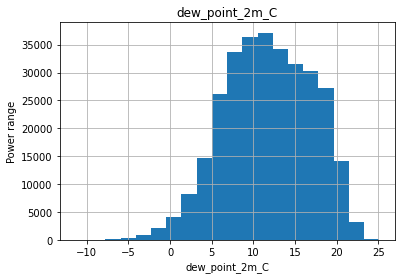

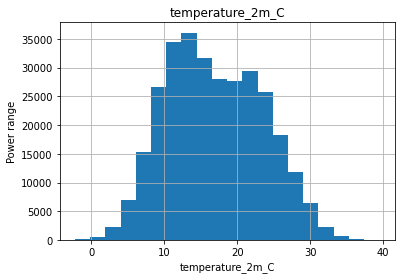

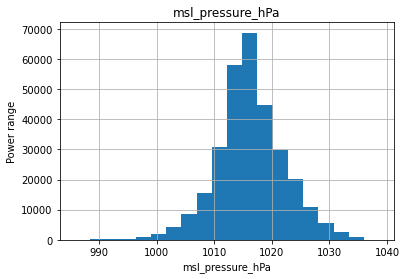

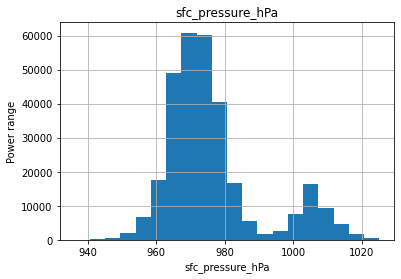

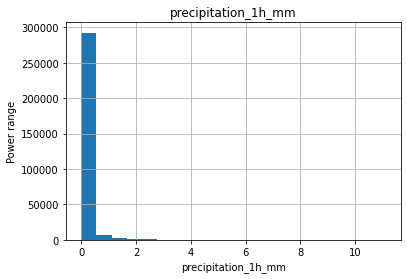

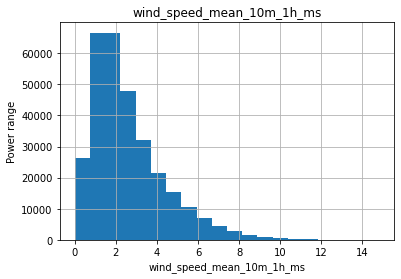

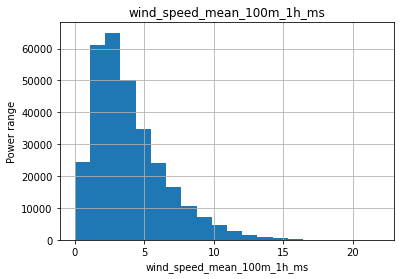

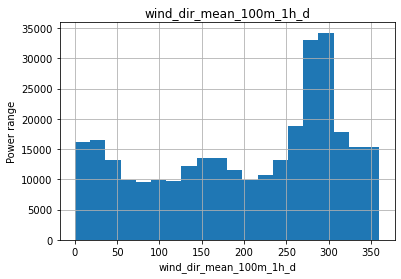

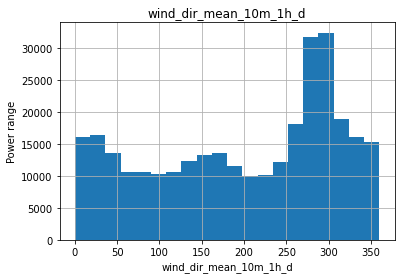

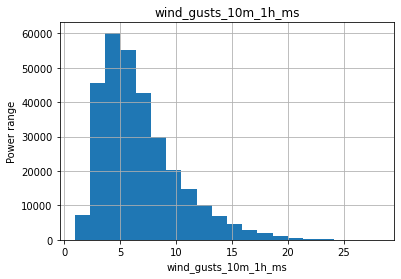

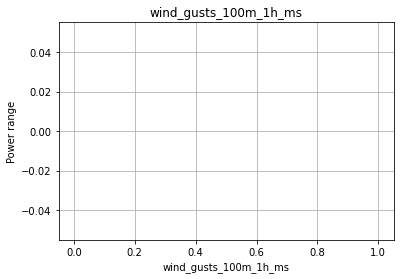

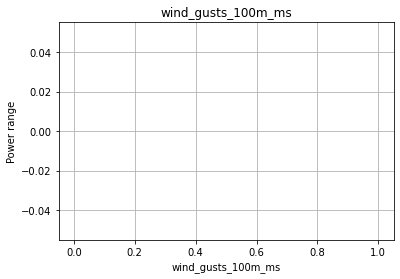

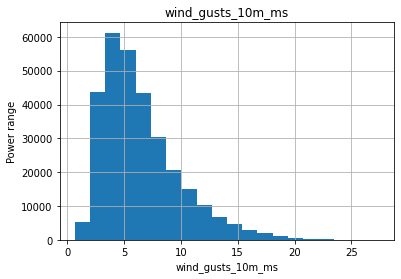

In [73]:
for var in weather_df.columns[3:]:
    analyse_continous(weather_df, var)

In [78]:
assert weather_df.plant_name_up.value_counts().tolist().sort() == energy_grouped.plant_name_up.unique().tolist().sort()

MERGE THE TWO DF

In [90]:
def merge_df(energy: DataFrame, weather: DataFrame) -> DataFrame:
    df: DataFrame = energy.merge(weather, left_on=['time', 'plant_name_up'], right_on=['timestamp_utc', 'plant_name_up'])
    df.drop(['timestamp_utc', 'id'], axis=1, inplace=True)
    df = df.sort_values(by=['plant_name_up','time'], ascending=True, ignore_index=True)
    
    return df

In [91]:
df = merge_df(energy_grouped, weather_df)

In [92]:
df.head()

,plant_name_up,time,kwh,dew_point_2m_C,temperature_2m_C,msl_pressure_hPa,sfc_pressure_hPa,precipitation_1h_mm,wind_speed_mean_10m_1h_ms,wind_speed_mean_100m_1h_ms,wind_dir_mean_100m_1h_d,wind_dir_mean_10m_1h_d,wind_gusts_10m_1h_ms,wind_gusts_100m_1h_ms,wind_gusts_100m_ms,wind_gusts_10m_ms
0,UP_MPNTLCDMRN_1,2016-12-31 23:00:00+00:00,225.000,-0.902831,4.980909,1028.935552,983.718765,0.000000e+00,1.381208,2.254668,26.531339,38.664892,4.240202,NaN,NaN,4.026465
1,UP_MPNTLCDMRN_1,2017-01-01 00:00:00+00:00,65.625,-0.783022,4.890773,1028.693079,983.524042,-1.734723e-15,1.278206,2.224647,22.408971,34.256697,4.027452,NaN,NaN,3.707296
2,UP_MPNTLCDMRN_1,2017-01-01 01:00:00+00:00,31.875,-0.565645,4.807044,1028.156679,983.034144,-1.734723e-15,1.211802,2.130597,17.880837,28.905779,3.713940,NaN,NaN,3.515824
3,UP_MPNTLCDMRN_1,2017-01-01 02:00:00+00:00,0.000,-0.331075,4.911959,1028.162779,983.062126,-1.734723e-15,1.017035,1.846413,15.523460,28.402692,3.547375,NaN,NaN,3.310938
4,UP_MPNTLCDMRN_1,2017-01-01 03:00:00+00:00,0.000,-0.668040,4.464566,1027.616920,982.551146,-1.734723e-15,0.715094,1.450024,0.706032,13.915324,3.362168,NaN,NaN,3.166429


In [93]:
df.shape

(243103, 16)

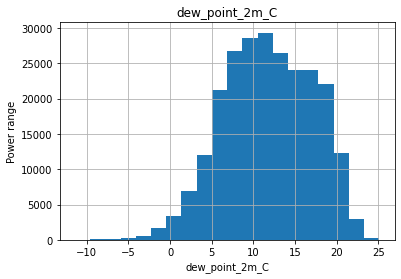

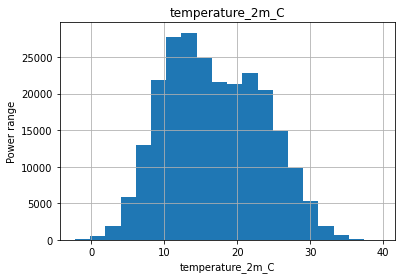

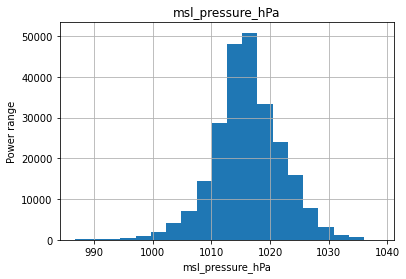

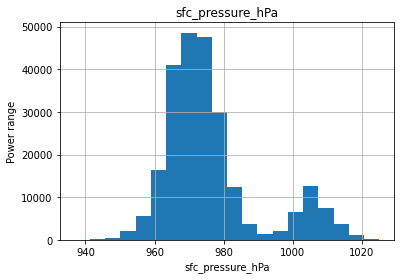

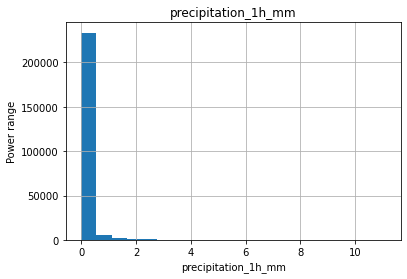

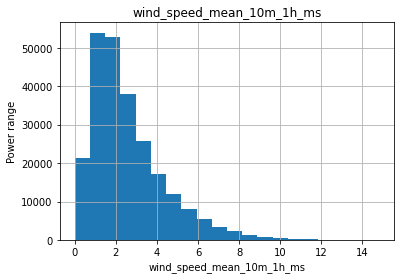

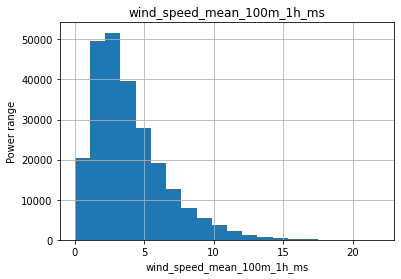

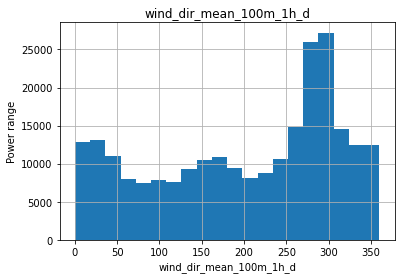

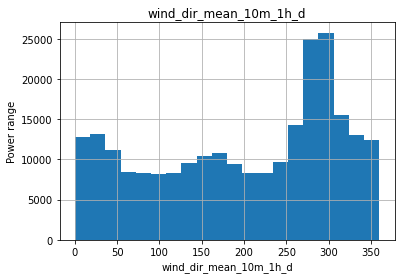

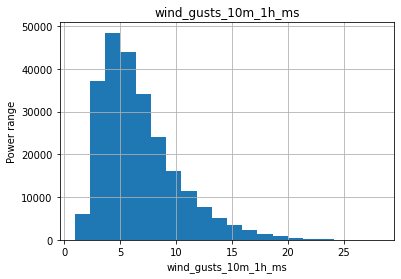

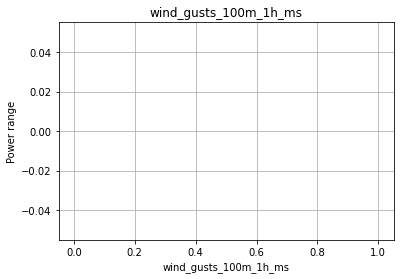

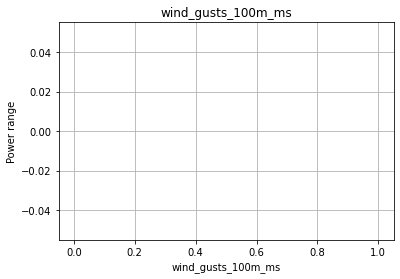

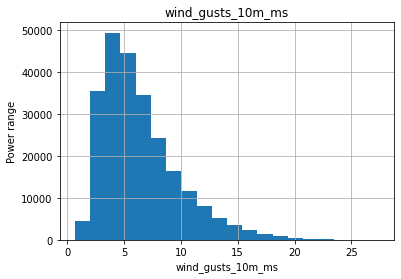

In [94]:
for var in df.columns[3:]:
    analyse_continous(df, var)